In [1]:
import os
import glob
import random
import itertools
import multiprocessing
import copy
import pprint
from pathlib import Path
import time
from datetime import datetime
from typing import Optional, Union, Tuple

import enum
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display
import seaborn as sns
from skimage.util import montage
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy import stats
from scipy.spatial.distance import cdist
import nrrd
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torchvision.ops.focal_loss import sigmoid_focal_loss
import torchio as tio
from unet import UNet
from torchinfo import summary


seed = 2022

random.seed(seed)
torch.manual_seed(seed)
num_workers = multiprocessing.cpu_count()


path_saved_models = os.path.join(os.getcwd(), '..', 'saved_models')
path_data = os.path.join(os.getcwd(), '..', 'data')
path_eda = os.path.join(path_data, 'eda')
path_segmentation = os.path.join(path_data, 'segmentation_xyz')
path_cropped = os.path.join(path_data, 'segmentation_xyz_cropped')

if not os.path.isdir(path_saved_models):
    os.mkdir(path_saved_models)
    
path_jigsaw_permutations = os.path.join(path_data, 'jigsaw_permutations')

if not os.path.isdir(path_jigsaw_permutations):
    os.mkdir(path_jigsaw_permutations)

In [2]:
def load_image(path):
    
    data, header = nrrd.read(path)
    data = data.astype(np.float32)
    affine = np.eye(4)
    
    return data, affine


class Visualizer:
    
    def montage_nrrd(self, image):
        if len(image.shape) > 2:
            return montage(image)
        else:
            warnings.warn('Pass a 3D volume', RuntimeWarning)
            return image
        
    def visualize(self, image, mask=None):
        
        if mask is None:
            fig, axes = plt.subplots(1, 1, figsize=(10, 10))
            axes.imshow(self.montage_nrrd(image))
            axes.set_axis_off()
        else:
            fig, axes = plt.subplots(1, 2, figsize=(40, 40))
        
            for i, data in enumerate([image, mask]):
                axes[i].imshow(self.montage_nrrd(data))
                axes[i].set_axis_off()
                
                
vis = Visualizer()

In [3]:
df = pd.read_csv(os.path.join(path_eda, 'spect_data.csv'))

df.head()

,image,image_slices,image_height,image_width,mask,mask_slices,mask_height,mask_width,slices_positive,positive_pixels_ratio,positive_ratio,positive_slice_ratio
0,1.nrrd,62,64,64,1_Segmentation.nrrd,62.0,64.0,64.0,11.0,0.002788,0.177419,0.18 %
1,2.nrrd,64,64,64,2_Segmentation.nrrd,64.0,64.0,64.0,9.0,0.001781,0.140625,0.14 %
2,3.nrrd,64,64,64,3_Segmentation.nrrd,64.0,64.0,64.0,12.0,0.006973,0.187500,0.19 %
3,4.nrrd,64,64,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.nrrd,128,128,128,5_Segmentation.nrrd,128.0,128.0,128.0,22.0,0.001923,0.171875,0.17 %


In [4]:
subjects = []

segmentations = list(df.loc[(df['mask'].isnull()), ['image']].to_records(index=False))
segmentations = list(map(
    lambda x: os.path.join(path_cropped, x[0]), 
    segmentations
))

for image_path in segmentations:

    subject = tio.Subject(spect=tio.ScalarImage(image_path, reader=load_image))
    subjects.append(subject)

dataset = tio.SubjectsDataset(subjects)
print(f"Dataset size: {len(dataset)} subjects")

Dataset size: 92 subjects


In [ ]:
classes = 1000
selection = 'max'
save_at = [99, 499, 999]


P_hat = np.array(list(itertools.permutations(list(range(9)), 9)))
n = P_hat.shape[0]

for i in tqdm(range(classes)):
    
    if i == 0:
        j = np.random.randint(n)
        P = np.array(P_hat[j]).reshape([1,-1])
    else:
        P = np.concatenate([P, P_hat[j].reshape([1,-1])], axis=0)

    P_hat = np.delete(P_hat, j, axis=0)
    D = cdist(P, P_hat, metric='hamming').mean(axis=0).flatten()
    j = D.argmax()

    if i in save_at:
        np.save(os.path.join(path_jigsaw_permutations, f'permutations_{i + 1}.npy'), P)

In [5]:
target_shape = (128, 128, 32)
max_displacement = (8, 8, 0)
num_control_points = 6

downsampling_factor = 2
original_spacing = 1
target_spacing = downsampling_factor / original_spacing  # in mm

patch_dim = 28
gap = 14


transforms = tio.Compose([
    tio.CropOrPad(target_shape=target_shape),
    tio.RandomFlip(axes=(0, 1, 2), p=0.5),
    tio.OneOf({
        tio.RandomAnisotropy(): 0.5,
        tio.RandomBlur(): 0.5,
        tio.RandomNoise(): 0.5,  
    }, p=0.5),
    tio.OneOf({
        tio.RandomAffine(): 0.5,
        tio.RandomElasticDeformation(max_displacement=max_displacement): 0.5,
        tio.RandomElasticDeformation(
            max_displacement=max_displacement,
            num_control_points=num_control_points
        ): 0.5,
        tio.RandomMotion(num_transforms=4, image_interpolation='linear'): 0.5
    }, p=0.8)
])

offset_x: 16, offset_y: 16
start_grid_x: 2, start_grid_y: 2


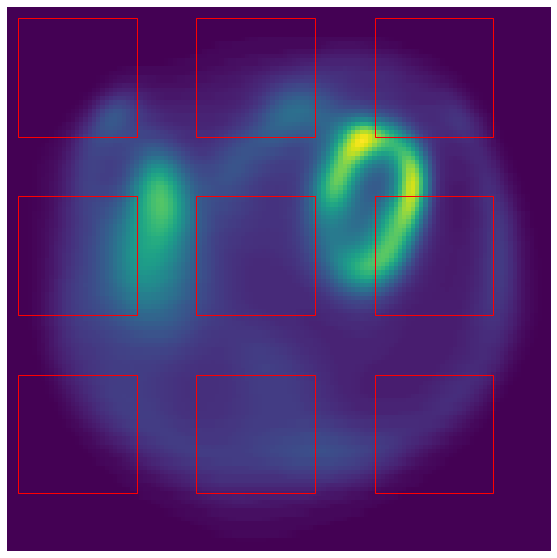

In [7]:
# paper - gap approx. half the patch width
# paper - random jitter for each patch approx. 7 pixels 

all_patch_loc = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]

subject_idx = np.random.randint(len(subjects))

volume = subjects[subject_idx].spect.data

# augment
volume = transforms(volume)

idx = np.random.randint(0, volume.shape[-1])
image = volume[0, ..., idx].numpy()

offset_x = image.shape[0] - (patch_dim * 3 + gap * 2)
offset_y = image.shape[1] - (patch_dim * 3 + gap * 2)

print(f'offset_x: {offset_x}, offset_y: {offset_y}')

start_grid_x = np.random.randint(0, offset_x)
start_grid_y = np.random.randint(0, offset_y)

print(f'start_grid_x: {start_grid_x}, start_grid_y: {start_grid_y}')

fig, ax = plt.subplots(figsize=(10,10))

plt.axis('off')
ax.imshow(image)

extracted_patches = []

for tempx, tempy in all_patch_loc:

    patch_x_pt = start_grid_x + patch_dim * (tempx - 1) + gap * (tempx - 1)
    patch_y_pt = start_grid_y + patch_dim * (tempy - 1) + gap * (tempy - 1)
    
    extracted_patches.append(
        image[
            patch_x_pt: patch_x_pt + patch_dim,
            patch_y_pt: patch_y_pt + patch_dim
        ]
    )
    rect = patches.Rectangle(
        (patch_x_pt, patch_y_pt), 
        width=patch_dim, 
        height=patch_dim,
        linewidth=1, 
        edgecolor='r', 
        facecolor='none'
    )
    ax.add_patch(rect)
    
extracted_patches = np.array(extracted_patches)

plt.show()

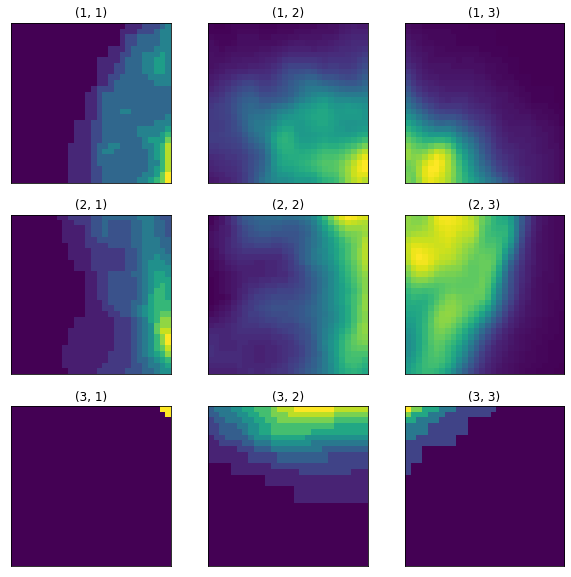

In [85]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for i, axis in enumerate(ax.flatten()):
    
        axis.imshow(extracted_patches[i])
        axis.set_title(str((i // 3 + 1, i % 3 + 1)))
        axis.set_xticks([])
        axis.set_yticks([])

In [86]:
permutations = 100

path_permutations = os.path.join(path_jigsaw_permutations, f'permutations_{permutations}.npy')

P = np.load(path_permutations)

In [87]:
rand_perm_idx = np.random.randint(P.shape[0])
random_permutation = P[rand_perm_idx]

permuted_patches = extracted_patches[random_permutation]

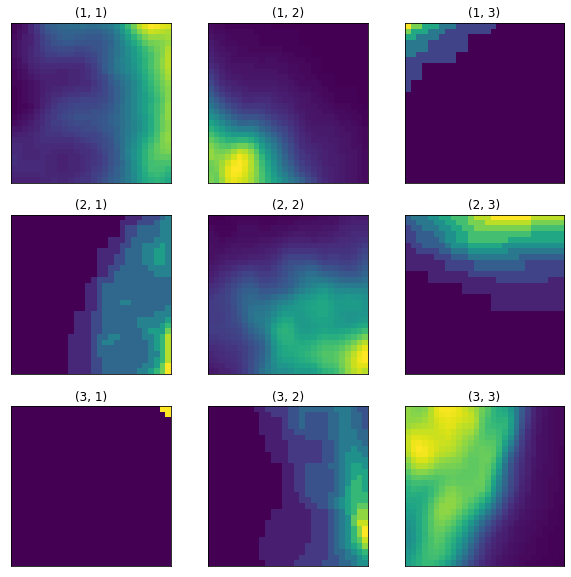

In [88]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for i, axis in enumerate(ax.flatten()):
    
        axis.imshow(permuted_patches[i])
        axis.set_title(str((i // 3 + 1, i % 3 + 1)))
        axis.set_xticks([])
        axis.set_yticks([])

In [5]:
class PermutePatches:
    def __init__(self, patch_dim, gap, path_permutations):
        self.patch_dim = patch_dim
        self.gap = gap
        self.patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]
        self.permutations = np.load(path_permutations)
        
    def __call__(self, sample):
        
        extracted_patches = []
        volume = sample.spect.data
        
        offset_x = volume.shape[1] - (self.patch_dim * 3 + self.gap * 2)
        offset_y = volume.shape[2] - (self.patch_dim * 3 + self.gap * 2)

        start_grid_x = np.random.randint(offset_x)
        start_grid_y = np.random.randint(offset_y)

        for tempx, tempy in self.patch_loc_arr:
            
            patch_x_pt = start_grid_x + self.patch_dim * (tempx - 1) + self.gap * (tempx - 1)
            patch_y_pt = start_grid_y + self.patch_dim * (tempy - 1) + self.gap * (tempy - 1)
            patch =  volume[
                :,
                patch_x_pt: patch_x_pt + self.patch_dim,
                patch_y_pt: patch_y_pt + self.patch_dim,
                :
            ]
            extracted_patches.append(patch.unsqueeze(0))
        
        extracted_patches = torch.stack(extracted_patches, dim=0)
        random_permutation_idx = np.random.randint(len(self.permutations))
        random_permutation = self.permutations[random_permutation_idx]
        permuted_patches = extracted_patches[random_permutation]
        
        return permuted_patches, torch.tensor(random_permutation_idx, dtype=torch.long)
        
        
class NormalizePatches:
    def __init__(self):
        self.normalize = tio.ZNormalization()
        
    def __call__(self, sample):
        
        patches, label = sample
        normalized_patches = []
        
        for patch in patches:
            
            try:
                patch = self.normalize(patch)
                normalized_patches.append(patch)
            except:
                normalized_patches.append(patch)
        
        return torch.cat(normalized_patches), label

In [6]:
class UnetEncoderSSL(nn.Module):
    def __init__(
        self, 
        patch_dim_x=28,
        patch_dim_z = 32,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        reduction_factor=64, # for dense connections from conv layer
        dropout=0,
        n_patches=9,
        n_permutations=100
    ):
        super().__init__()
        
        self.patch_dim_x = patch_dim_x
        self.patch_dim_z = patch_dim_z
        self.num_encoding_blocks = num_encoding_blocks
        self.normalization = normalization
        self.dropout = dropout
        self.n_patches = n_patches
        self.n_permutations = n_permutations
        
        self.encoder = UNet(
            in_channels=1,
            out_classes=2,
            dimensions=3,
            num_encoding_blocks=num_encoding_blocks,
            out_channels_first_layer=out_channels_first_layer,
            normalization=normalization,
            upsampling_type='linear',
            padding=True,
            activation='PReLU',
            dropout=dropout
        ).encoder

        dx = patch_dim_x // 2**(num_encoding_blocks - 1)
        dz = patch_dim_z // 2**(num_encoding_blocks - 1)
        n_in = (num_encoding_blocks + 1) * out_channels_first_layer * dx**2 * dz
        n_out = n_in // reduction_factor
        
        self.fc1 = nn.Sequential(
            nn.Linear(n_in, n_out),
            nn.PReLU(),
            nn.BatchNorm1d(n_out)
        )
        self.fc = nn.Sequential(
            nn.Linear(self.n_patches * n_out, n_out // 2),
            nn.PReLU(),
            nn.Linear(n_out // 2, self.n_permutations)
        )
        
        
    def forward_once(self, x):
        
        skip_connections, output = self.encoder(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        
        return output
    
    def forward(self, x):
        
        B, T, C, H, W, Z = x.size()
        x = x.transpose(0, 1)
        
        encoded_data = []
        
        for patch in x:
            skip_connections, output = self.encoder(patch)
            output = output.view(output.shape[0], -1)
            output = self.fc1(output)
            encoded_data.append(output)
            
        x = torch.cat(encoded_data, dim=1)
        x = self.fc(x.view(B, -1))
        
        return x
            
    def save(self, checkpoint):
        torch.save(self.state_dict(), checkpoint)

In [38]:
class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'
    

def prepare_batch(batch, device):
    
    inputs, targets = batch
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    return inputs, targets


def run_epoch(epoch_idx, action, loader, model, criterion, optimizer):
    
    is_training = action == Action.TRAIN
    epoch_losses = []
    accuracies = []
    model.train(is_training)
    
    for batch_idx, batch in enumerate(tqdm(loader)):
        
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
    
        with torch.set_grad_enabled(is_training):
            
            # CrossEntropyLoss combines LogSoftmax with NLLLOSS
            outputs = model(inputs)
            batch_losses = criterion(outputs, targets)
            batch_loss = batch_losses.mean()
            accuracy = ((outputs.argmax(axis=1) == targets).sum() / len(outputs)).cpu().item()
            accuracies.append(accuracy)
            
            if is_training:
            
                batch_loss.backward()
                optimizer.step()
            
            epoch_losses.append(batch_loss.item())
    
    epoch_losses = np.array(epoch_losses).mean()
    accuracies = np.array(accuracies).mean()
   
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}\tAccuracy: {accuracies:.2f}')
    
    return time.time(), epoch_losses, accuracies


def train(num_epochs, training_loader, validation_loader, model, criterion, optimizer, path_save, early_stop):
    
    train_losses = []
    val_losses = []
    best_val_acc = -np.inf
    early_stop_counter = 0
    
    for epoch_idx in range(1, num_epochs + 1):
    
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, criterion, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, criterion, optimizer))
        
        _, val_loss, val_acc = val_losses[-1]
        
        if val_acc > best_val_acc:
            print(f'Saving model at epoch: {epoch_idx}')
            best_val_acc = val_acc
            early_stop_counter = 0
            checkpoint = {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'weights': model.state_dict()
            }
            torch.save(checkpoint, path_save)
        else:
            early_stop_counter += 1
            
            if early_stop_counter >= early_stop:
                print(f'Stopping after {epoch_idx} iterations...')
                break
    
    return np.array(train_losses), np.array(val_losses)


def plot_times(axis, losses, label):
    
    times, losses, _ = losses.transpose(1, 0)
    times = [datetime.fromtimestamp(x) for x in times]
    axis.plot(times, losses.flatten(), label=label)
    
    
def plot_epochs(axis, losses, label):
    
    _, losses, _ = losses.transpose(1, 0)
    epochs = [i for i in range(1, len(losses.flatten()) + 1)]
    axis.plot(epochs, losses.flatten(), label=label)
    
    
def plot_accuracies(axis, losses, label):
    
    _, losses, accuracies = losses.transpose(1, 0)
    epochs = [i for i in range(1, len(losses.flatten()) + 1)]
    axis.plot(epochs, accuracies.flatten(), label=label)

## Train with 500 permutations

In [39]:
target_shape = (128, 128, 32)
max_displacement = (8, 8, 0)
num_control_points = 10

patch_dim = 28
gap = 14

n_permutations = 500
path_permutations = os.path.join(path_jigsaw_permutations, f'permutations_{n_permutations}.npy')


training_transform = tio.Compose([
    tio.CropOrPad(target_shape=target_shape),
    tio.RandomFlip(axes=(0, 1, 2), p=0.5),
    tio.OneOf({
        tio.RandomAnisotropy(): 0.5,
        tio.RandomBlur(): 0.5,
        tio.RandomNoise(): 0.5,  
    }, p=0.5),
    tio.OneOf({
        tio.RandomAffine(): 0.5,
        tio.RandomElasticDeformation(max_displacement=max_displacement): 0.5,
        tio.RandomElasticDeformation(
            max_displacement=max_displacement,
            num_control_points=num_control_points
        ): 0.5,
        tio.RandomMotion(num_transforms=4, image_interpolation='linear'): 0.5
    }, p=0.8),
    PermutePatches(patch_dim, gap, path_permutations),
    NormalizePatches()
])

validation_transform = tio.Compose([
    tio.CropOrPad(target_shape=target_shape),
    PermutePatches(patch_dim, gap, path_permutations),
    NormalizePatches()
])

In [40]:
training_split_ratio = 0.85

num_subjects = len(dataset)

num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = (num_training_subjects, num_validation_subjects)
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(training_subjects, transform=training_transform)
validation_set = tio.SubjectsDataset(validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 78 subjects
Validation set: 14 subjects


In [41]:
training_batch_size = 8
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=0
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=0
)

In [42]:
exp_name = f'jiggsaw_puzzle_{n_permutations}_instance_norm_aug'

path_save = os.path.join(path_saved_models, f'{exp_name}.pth')

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

num_epochs = 200
learning_rate = 1e-3
early_stop = 30

model = UnetEncoderSSL(normalization='instance', n_permutations=n_permutations)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = train(num_epochs, training_loader, validation_loader, 
                                 model, criterion, optimizer, path_save, early_stop)

Starting epoch 1


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.226	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.122	Accuracy: 0.00
Saving model at epoch: 1
Starting epoch 2


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.124	Accuracy: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.413	Accuracy: 0.00
Starting epoch 3


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.138	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.290	Accuracy: 0.00
Starting epoch 4


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.239	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.792	Accuracy: 0.07
Saving model at epoch: 4
Starting epoch 5


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.288	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.979	Accuracy: 0.07
Starting epoch 6


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.303	Accuracy: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.333	Accuracy: 0.00
Starting epoch 7


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.133	Accuracy: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.855	Accuracy: 0.00
Starting epoch 8


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.264	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.585	Accuracy: 0.00
Starting epoch 9


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.878	Accuracy: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.139	Accuracy: 0.07
Starting epoch 10


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.169	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.448	Accuracy: 0.00
Starting epoch 11


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.100	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.729	Accuracy: 0.00
Starting epoch 12


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.054	Accuracy: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.807	Accuracy: 0.21
Saving model at epoch: 12
Starting epoch 13


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.549	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.373	Accuracy: 0.07
Starting epoch 14


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.698	Accuracy: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.738	Accuracy: 0.07
Starting epoch 15


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.411	Accuracy: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.325	Accuracy: 0.21
Starting epoch 16


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.477	Accuracy: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.148	Accuracy: 0.21
Starting epoch 17


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.360	Accuracy: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.876	Accuracy: 0.14
Starting epoch 18


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.285	Accuracy: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.175	Accuracy: 0.07
Starting epoch 19


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.186	Accuracy: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.239	Accuracy: 0.07
Starting epoch 20


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.178	Accuracy: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.702	Accuracy: 0.21
Starting epoch 21


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.698	Accuracy: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.727	Accuracy: 0.29
Saving model at epoch: 21
Starting epoch 22


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.473	Accuracy: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.194	Accuracy: 0.36
Saving model at epoch: 22
Starting epoch 23


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.298	Accuracy: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.357	Accuracy: 0.29
Starting epoch 24


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.888	Accuracy: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.985	Accuracy: 0.29
Starting epoch 25


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.156	Accuracy: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.918	Accuracy: 0.29
Starting epoch 26


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.854	Accuracy: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.090	Accuracy: 0.29
Starting epoch 27


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.640	Accuracy: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.164	Accuracy: 0.43
Saving model at epoch: 27
Starting epoch 28


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.544	Accuracy: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.842	Accuracy: 0.57
Saving model at epoch: 28
Starting epoch 29


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.464	Accuracy: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.464	Accuracy: 0.36
Starting epoch 30


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.953	Accuracy: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.038	Accuracy: 0.50
Starting epoch 31


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.913	Accuracy: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.814	Accuracy: 0.21
Starting epoch 32


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.713	Accuracy: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.592	Accuracy: 0.50
Starting epoch 33


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.034	Accuracy: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.496	Accuracy: 0.43
Starting epoch 34


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.105	Accuracy: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.426	Accuracy: 0.29
Starting epoch 35


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.449	Accuracy: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.441	Accuracy: 0.50
Starting epoch 36


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.944	Accuracy: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.995	Accuracy: 0.64
Saving model at epoch: 36
Starting epoch 37


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.518	Accuracy: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.929	Accuracy: 0.64
Starting epoch 38


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.441	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.614	Accuracy: 0.57
Starting epoch 39


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.529	Accuracy: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.026	Accuracy: 0.50
Starting epoch 40


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.972	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.527	Accuracy: 0.36
Starting epoch 41


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.876	Accuracy: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.103	Accuracy: 0.64
Starting epoch 42


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.178	Accuracy: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.189	Accuracy: 0.57
Starting epoch 43


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.941	Accuracy: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.335	Accuracy: 0.50
Starting epoch 44


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.655	Accuracy: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.823	Accuracy: 0.64
Starting epoch 45


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.097	Accuracy: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.660	Accuracy: 0.57
Starting epoch 46


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.875	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.200	Accuracy: 0.57
Starting epoch 47


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.838	Accuracy: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.859	Accuracy: 0.64
Starting epoch 48


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.489	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.007	Accuracy: 0.50
Starting epoch 49


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.270	Accuracy: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.617	Accuracy: 0.50
Starting epoch 50


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.723	Accuracy: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.440	Accuracy: 0.43
Starting epoch 51


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.213	Accuracy: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.784	Accuracy: 0.64
Starting epoch 52


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.702	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.153	Accuracy: 0.64
Starting epoch 53


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.708	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.309	Accuracy: 0.64
Starting epoch 54


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.485	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.610	Accuracy: 0.71
Saving model at epoch: 54
Starting epoch 55


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.139	Accuracy: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.431	Accuracy: 0.71
Starting epoch 56


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.648	Accuracy: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.416	Accuracy: 0.57
Starting epoch 57


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.191	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.000	Accuracy: 0.79
Saving model at epoch: 57
Starting epoch 58


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.517	Accuracy: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.486	Accuracy: 0.79
Starting epoch 59


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.120	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.199	Accuracy: 0.57
Starting epoch 60


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.538	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.737	Accuracy: 0.64
Starting epoch 61


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.138	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.964	Accuracy: 0.71
Starting epoch 62


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.967	Accuracy: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.230	Accuracy: 0.64
Starting epoch 63


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.010	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.010	Accuracy: 0.71
Starting epoch 64


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.000	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.204	Accuracy: 0.50
Starting epoch 65


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.361	Accuracy: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.328	Accuracy: 0.64
Starting epoch 66


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.048	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.208	Accuracy: 0.71
Starting epoch 67


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.009	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.601	Accuracy: 0.71
Starting epoch 68


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.115	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.738	Accuracy: 0.64
Starting epoch 69


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.037	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.517	Accuracy: 0.86
Saving model at epoch: 69
Starting epoch 70


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.992	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.135	Accuracy: 0.79
Starting epoch 71


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.839	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.720	Accuracy: 0.79
Starting epoch 72


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.922	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.070	Accuracy: 0.79
Starting epoch 73


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.958	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.765	Accuracy: 0.79
Starting epoch 74


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.865	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.220	Accuracy: 0.71
Starting epoch 75


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.687	Accuracy: 0.87


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.245	Accuracy: 0.71
Starting epoch 76


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.919	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.138	Accuracy: 0.71
Starting epoch 77


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.962	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.066	Accuracy: 0.79
Starting epoch 78


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.838	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.536	Accuracy: 0.93
Saving model at epoch: 78
Starting epoch 79


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.033	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.020	Accuracy: 0.79
Starting epoch 80


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.452	Accuracy: 0.90


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.664	Accuracy: 0.71
Starting epoch 81


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.189	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.954	Accuracy: 0.71
Starting epoch 82


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.615	Accuracy: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.017	Accuracy: 0.71
Starting epoch 83


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.714	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.789	Accuracy: 0.79
Starting epoch 84


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.377	Accuracy: 0.93


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.299	Accuracy: 0.79
Starting epoch 85


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.704	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.739	Accuracy: 0.64
Starting epoch 86


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.843	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.997	Accuracy: 0.71
Starting epoch 87


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.654	Accuracy: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.019	Accuracy: 0.79
Starting epoch 88


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.577	Accuracy: 0.89


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.615	Accuracy: 0.86
Starting epoch 89


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.708	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.101	Accuracy: 1.00
Saving model at epoch: 89
Starting epoch 90


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.488	Accuracy: 0.86


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.371	Accuracy: 0.93
Starting epoch 91


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.602	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.471	Accuracy: 0.71
Starting epoch 92


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.914	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.865	Accuracy: 0.79
Starting epoch 93


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.471	Accuracy: 0.90


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.859	Accuracy: 0.79
Starting epoch 94


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.681	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.483	Accuracy: 0.93
Starting epoch 95


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.692	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.173	Accuracy: 0.71
Starting epoch 96


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.609	Accuracy: 0.86


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.963	Accuracy: 0.79
Starting epoch 97


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.650	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.642	Accuracy: 0.71
Starting epoch 98


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.729	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.062	Accuracy: 0.64
Starting epoch 99


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.913	Accuracy: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.398	Accuracy: 0.79
Starting epoch 100


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.610	Accuracy: 0.85


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.456	Accuracy: 0.93
Starting epoch 101


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.791	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.196	Accuracy: 0.79
Starting epoch 102


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.706	Accuracy: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.075	Accuracy: 0.64
Starting epoch 103


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.671	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.544	Accuracy: 0.86
Starting epoch 104


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.693	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.935	Accuracy: 0.86
Starting epoch 105


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.673	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.423	Accuracy: 0.86
Starting epoch 106


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.555	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.514	Accuracy: 0.93
Starting epoch 107


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.369	Accuracy: 0.89


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.443	Accuracy: 0.71
Starting epoch 108


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.779	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.965	Accuracy: 0.71
Starting epoch 109


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.671	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Accuracy: 0.93
Starting epoch 110


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.557	Accuracy: 0.85


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.715	Accuracy: 0.71
Starting epoch 111


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.535	Accuracy: 0.85


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.946	Accuracy: 0.79
Starting epoch 112


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.830	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.475	Accuracy: 0.86
Starting epoch 113


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.737	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.269	Accuracy: 0.93
Starting epoch 114


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.424	Accuracy: 0.89


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.029	Accuracy: 0.71
Starting epoch 115


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.629	Accuracy: 0.85


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.770	Accuracy: 0.79
Starting epoch 116


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.465	Accuracy: 0.88


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.802	Accuracy: 0.71
Starting epoch 117


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.460	Accuracy: 0.84


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.576	Accuracy: 0.93
Starting epoch 118


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.432	Accuracy: 0.85


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.442	Accuracy: 0.86
Starting epoch 119


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.440	Accuracy: 0.89


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.389	Accuracy: 0.64
Stopping after 119 iterations...


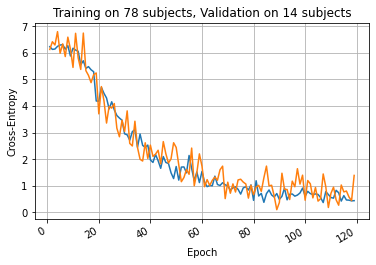

In [43]:
fig, ax = plt.subplots()
plot_epochs(ax, train_losses, 'Training')
plot_epochs(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-Entropy')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
fig.autofmt_xdate()

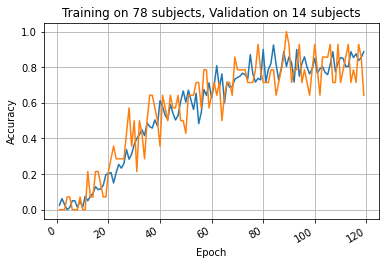

In [44]:
fig, ax = plt.subplots()
plot_accuracies(ax, train_losses, 'Training')
plot_accuracies(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
fig.autofmt_xdate()

## Train with 100 permutations

In [45]:
target_shape = (128, 128, 32)
max_displacement = (8, 8, 0)
num_control_points = 10

patch_dim = 28
gap = 14

n_permutations = 1000
path_permutations = os.path.join(path_jigsaw_permutations, f'permutations_{n_permutations}.npy')


training_transform = tio.Compose([
    tio.CropOrPad(target_shape=target_shape),
    tio.RandomFlip(axes=(0, 1, 2), p=0.5),
    tio.OneOf({
        tio.RandomAnisotropy(): 0.5,
        tio.RandomBlur(): 0.5,
        tio.RandomNoise(): 0.5,  
    }, p=0.5),
    tio.OneOf({
        tio.RandomAffine(): 0.5,
        tio.RandomElasticDeformation(max_displacement=max_displacement): 0.5,
        tio.RandomElasticDeformation(
            max_displacement=max_displacement,
            num_control_points=num_control_points
        ): 0.5,
        tio.RandomMotion(num_transforms=4, image_interpolation='linear'): 0.5
    }, p=0.8),
    PermutePatches(patch_dim, gap, path_permutations),
    NormalizePatches()
])

validation_transform = tio.Compose([
    tio.CropOrPad(target_shape=target_shape),
    PermutePatches(patch_dim, gap, path_permutations),
    NormalizePatches()
])

In [46]:
training_split_ratio = 0.85

num_subjects = len(dataset)

num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = (num_training_subjects, num_validation_subjects)
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(training_subjects, transform=training_transform)
validation_set = tio.SubjectsDataset(validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 78 subjects
Validation set: 14 subjects


In [47]:
training_batch_size = 8
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=0
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=0
)

In [48]:
exp_name = f'jiggsaw_puzzle_{n_permutations}_instance_norm_aug'

path_save = os.path.join(path_saved_models, f'{exp_name}.pth')

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

num_epochs = 200
learning_rate = 1e-3
early_stop = 30

model = UnetEncoderSSL(normalization='instance', n_permutations=n_permutations)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = train(num_epochs, training_loader, validation_loader, 
                                 model, criterion, optimizer, path_save, early_stop)

Starting epoch 1


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.952	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.149	Accuracy: 0.00
Saving model at epoch: 1
Starting epoch 2


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.070	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.872	Accuracy: 0.07
Saving model at epoch: 2
Starting epoch 3


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.993	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.879	Accuracy: 0.00
Starting epoch 4


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.874	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.519	Accuracy: 0.07
Starting epoch 5


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.997	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.157	Accuracy: 0.00
Starting epoch 6


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.100	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.625	Accuracy: 0.00
Starting epoch 7


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.164	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.234	Accuracy: 0.00
Starting epoch 8


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.134	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.652	Accuracy: 0.07
Starting epoch 9


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.109	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.059	Accuracy: 0.07
Starting epoch 10


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.094	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.619	Accuracy: 0.00
Starting epoch 11


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.944	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.337	Accuracy: 0.00
Starting epoch 12


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.099	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.844	Accuracy: 0.00
Starting epoch 13


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.038	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.605	Accuracy: 0.00
Starting epoch 14


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.934	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.102	Accuracy: 0.00
Starting epoch 15


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.981	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.774	Accuracy: 0.07
Starting epoch 16


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.752	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.216	Accuracy: 0.00
Starting epoch 17


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.467	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.336	Accuracy: 0.07
Starting epoch 18


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.516	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.484	Accuracy: 0.07
Starting epoch 19


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.515	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.780	Accuracy: 0.00
Starting epoch 20


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.461	Accuracy: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.858	Accuracy: 0.00
Starting epoch 21


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.354	Accuracy: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.723	Accuracy: 0.00
Starting epoch 22


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.096	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.623	Accuracy: 0.00
Starting epoch 23


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.036	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.741	Accuracy: 0.07
Starting epoch 24


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.097	Accuracy: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.331	Accuracy: 0.00
Starting epoch 25


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.959	Accuracy: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.134	Accuracy: 0.00
Starting epoch 26


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.121	Accuracy: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.986	Accuracy: 0.07
Starting epoch 27


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.841	Accuracy: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.570	Accuracy: 0.14
Saving model at epoch: 27
Starting epoch 28


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.701	Accuracy: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.273	Accuracy: 0.07
Starting epoch 29


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.008	Accuracy: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.983	Accuracy: 0.00
Starting epoch 30


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.659	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.498	Accuracy: 0.21
Saving model at epoch: 30
Starting epoch 31


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.429	Accuracy: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.625	Accuracy: 0.21
Starting epoch 32


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.530	Accuracy: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.638	Accuracy: 0.21
Starting epoch 33


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.354	Accuracy: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.985	Accuracy: 0.14
Starting epoch 34


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.562	Accuracy: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.176	Accuracy: 0.21
Starting epoch 35


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.398	Accuracy: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.121	Accuracy: 0.21
Starting epoch 36


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.143	Accuracy: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.323	Accuracy: 0.00
Starting epoch 37


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.135	Accuracy: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.570	Accuracy: 0.21
Starting epoch 38


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.931	Accuracy: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.777	Accuracy: 0.14
Starting epoch 39


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.985	Accuracy: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.019	Accuracy: 0.14
Starting epoch 40


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.200	Accuracy: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.689	Accuracy: 0.21
Starting epoch 41


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.541	Accuracy: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.082	Accuracy: 0.21
Starting epoch 42


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.861	Accuracy: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.926	Accuracy: 0.43
Saving model at epoch: 42
Starting epoch 43


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.636	Accuracy: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.519	Accuracy: 0.21
Starting epoch 44


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.463	Accuracy: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.385	Accuracy: 0.14
Starting epoch 45


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.684	Accuracy: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.053	Accuracy: 0.36
Starting epoch 46


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.504	Accuracy: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.471	Accuracy: 0.36
Starting epoch 47


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.369	Accuracy: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.961	Accuracy: 0.50
Saving model at epoch: 47
Starting epoch 48


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.463	Accuracy: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.024	Accuracy: 0.29
Starting epoch 49


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.663	Accuracy: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.267	Accuracy: 0.21
Starting epoch 50


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.724	Accuracy: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.557	Accuracy: 0.43
Starting epoch 51


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.199	Accuracy: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.981	Accuracy: 0.29
Starting epoch 52


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.131	Accuracy: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.238	Accuracy: 0.36
Starting epoch 53


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.080	Accuracy: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.931	Accuracy: 0.36
Starting epoch 54


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.662	Accuracy: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.374	Accuracy: 0.43
Starting epoch 55


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.753	Accuracy: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.978	Accuracy: 0.14
Starting epoch 56


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.322	Accuracy: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.438	Accuracy: 0.50
Starting epoch 57


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.693	Accuracy: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.457	Accuracy: 0.21
Starting epoch 58


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.541	Accuracy: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.663	Accuracy: 0.36
Starting epoch 59


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.275	Accuracy: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.496	Accuracy: 0.36
Starting epoch 60


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.548	Accuracy: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.138	Accuracy: 0.43
Starting epoch 61


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.608	Accuracy: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.249	Accuracy: 0.71
Saving model at epoch: 61
Starting epoch 62


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.493	Accuracy: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.779	Accuracy: 0.43
Starting epoch 63


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.440	Accuracy: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.499	Accuracy: 0.43
Starting epoch 64


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.939	Accuracy: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.982	Accuracy: 0.21
Starting epoch 65


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.823	Accuracy: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.835	Accuracy: 0.29
Starting epoch 66


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.077	Accuracy: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.683	Accuracy: 0.50
Starting epoch 67


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.437	Accuracy: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.393	Accuracy: 0.36
Starting epoch 68


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.701	Accuracy: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.709	Accuracy: 0.43
Starting epoch 69


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.891	Accuracy: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.831	Accuracy: 0.50
Starting epoch 70


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.926	Accuracy: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.171	Accuracy: 0.21
Starting epoch 71


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.069	Accuracy: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.839	Accuracy: 0.57
Starting epoch 72


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.964	Accuracy: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.602	Accuracy: 0.43
Starting epoch 73


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.856	Accuracy: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.284	Accuracy: 0.43
Starting epoch 74


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.084	Accuracy: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.339	Accuracy: 0.50
Starting epoch 75


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.756	Accuracy: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.086	Accuracy: 0.36
Starting epoch 76


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.424	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.899	Accuracy: 0.43
Starting epoch 77


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.988	Accuracy: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.162	Accuracy: 0.50
Starting epoch 78


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.244	Accuracy: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.558	Accuracy: 0.50
Starting epoch 79


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.920	Accuracy: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.534	Accuracy: 0.43
Starting epoch 80


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.442	Accuracy: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.291	Accuracy: 0.50
Starting epoch 81


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.292	Accuracy: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.420	Accuracy: 0.64
Starting epoch 82


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.145	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.483	Accuracy: 0.57
Starting epoch 83


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.329	Accuracy: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.053	Accuracy: 0.50
Starting epoch 84


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.711	Accuracy: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.733	Accuracy: 0.43
Starting epoch 85


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.152	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.571	Accuracy: 0.64
Starting epoch 86


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.305	Accuracy: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.601	Accuracy: 0.71
Starting epoch 87


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.646	Accuracy: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.450	Accuracy: 0.71
Starting epoch 88


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.875	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.443	Accuracy: 0.50
Starting epoch 89


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.168	Accuracy: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.276	Accuracy: 0.50
Starting epoch 90


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.812	Accuracy: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.465	Accuracy: 0.79
Saving model at epoch: 90
Starting epoch 91


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.136	Accuracy: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.300	Accuracy: 0.50
Starting epoch 92


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.712	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.140	Accuracy: 0.64
Starting epoch 93


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.843	Accuracy: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.287	Accuracy: 0.71
Starting epoch 94


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.107	Accuracy: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.649	Accuracy: 0.71
Starting epoch 95


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.641	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.341	Accuracy: 0.57
Starting epoch 96


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.938	Accuracy: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.451	Accuracy: 0.79
Starting epoch 97


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.795	Accuracy: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.461	Accuracy: 0.64
Starting epoch 98


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.657	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.214	Accuracy: 0.50
Starting epoch 99


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.753	Accuracy: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.808	Accuracy: 0.79
Starting epoch 100


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.359	Accuracy: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.495	Accuracy: 0.71
Starting epoch 101


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.607	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.535	Accuracy: 0.50
Starting epoch 102


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.034	Accuracy: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.514	Accuracy: 0.50
Starting epoch 103


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.593	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.994	Accuracy: 0.79
Starting epoch 104


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.584	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.970	Accuracy: 0.86
Saving model at epoch: 104
Starting epoch 105


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.736	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.549	Accuracy: 0.57
Starting epoch 106


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.665	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.871	Accuracy: 0.71
Starting epoch 107


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.736	Accuracy: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.902	Accuracy: 0.71
Starting epoch 108


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.307	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.092	Accuracy: 0.71
Starting epoch 109


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.584	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.042	Accuracy: 0.79
Starting epoch 110


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.335	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.840	Accuracy: 0.71
Starting epoch 111


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.585	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.351	Accuracy: 0.71
Starting epoch 112


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.871	Accuracy: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.925	Accuracy: 0.79
Starting epoch 113


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.315	Accuracy: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.441	Accuracy: 0.57
Starting epoch 114


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.588	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.639	Accuracy: 0.86
Starting epoch 115


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.623	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.920	Accuracy: 0.79
Starting epoch 116


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.649	Accuracy: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.004	Accuracy: 0.86
Starting epoch 117


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.513	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.244	Accuracy: 0.86
Starting epoch 118


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.362	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.466	Accuracy: 0.93
Saving model at epoch: 118
Starting epoch 119


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.753	Accuracy: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.813	Accuracy: 0.79
Starting epoch 120


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.680	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.501	Accuracy: 0.93
Starting epoch 121


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.374	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.468	Accuracy: 0.86
Starting epoch 122


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.121	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.196	Accuracy: 0.64
Starting epoch 123


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.588	Accuracy: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.141	Accuracy: 0.71
Starting epoch 124


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.600	Accuracy: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.949	Accuracy: 0.79
Starting epoch 125


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.228	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.187	Accuracy: 0.79
Starting epoch 126


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.266	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.775	Accuracy: 0.79
Starting epoch 127


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.177	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.334	Accuracy: 0.64
Starting epoch 128


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.207	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.895	Accuracy: 0.64
Starting epoch 129


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.378	Accuracy: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.886	Accuracy: 0.86
Starting epoch 130


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.426	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.061	Accuracy: 0.71
Starting epoch 131


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.207	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.905	Accuracy: 0.79
Starting epoch 132


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.009	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.146	Accuracy: 0.79
Starting epoch 133


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.292	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.614	Accuracy: 0.57
Starting epoch 134


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.122	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.343	Accuracy: 0.79
Starting epoch 135


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.087	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.105	Accuracy: 1.00
Saving model at epoch: 135
Starting epoch 136


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.249	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.423	Accuracy: 0.93
Starting epoch 137


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.360	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.597	Accuracy: 0.86
Starting epoch 138


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.913	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.658	Accuracy: 0.79
Starting epoch 139


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.777	Accuracy: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.662	Accuracy: 0.86
Starting epoch 140


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.008	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.513	Accuracy: 0.93
Starting epoch 141


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.101	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.731	Accuracy: 0.71
Starting epoch 142


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.162	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.388	Accuracy: 0.86
Starting epoch 143


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.027	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.029	Accuracy: 0.64
Starting epoch 144


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.050	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.483	Accuracy: 0.86
Starting epoch 145


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.080	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.867	Accuracy: 0.71
Starting epoch 146


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.944	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.683	Accuracy: 0.86
Starting epoch 147


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.445	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.772	Accuracy: 0.71
Starting epoch 148


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.345	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.720	Accuracy: 0.71
Starting epoch 149


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.803	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.105	Accuracy: 0.64
Starting epoch 150


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.948	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.644	Accuracy: 0.71
Starting epoch 151


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.201	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.536	Accuracy: 0.79
Starting epoch 152


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.146	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.206	Accuracy: 0.71
Starting epoch 153


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.825	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.675	Accuracy: 0.79
Starting epoch 154


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.818	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.127	Accuracy: 0.57
Starting epoch 155


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.952	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.980	Accuracy: 0.79
Starting epoch 156


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.220	Accuracy: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.677	Accuracy: 0.79
Starting epoch 157


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.017	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.304	Accuracy: 1.00
Starting epoch 158


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.766	Accuracy: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.330	Accuracy: 0.64
Starting epoch 159


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.786	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.120	Accuracy: 0.79
Starting epoch 160


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.869	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.636	Accuracy: 0.79
Starting epoch 161


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.987	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.519	Accuracy: 0.86
Starting epoch 162


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.900	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.615	Accuracy: 0.79
Starting epoch 163


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.819	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.070	Accuracy: 1.00
Starting epoch 164


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.927	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.653	Accuracy: 0.79
Starting epoch 165


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.991	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.929	Accuracy: 0.50
Stopping after 165 iterations...


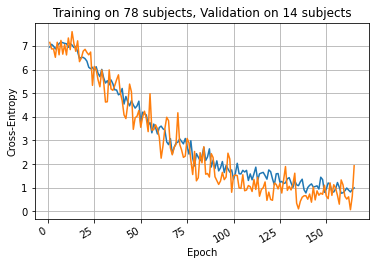

In [49]:
fig, ax = plt.subplots()
plot_epochs(ax, train_losses, 'Training')
plot_epochs(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-Entropy')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
fig.autofmt_xdate()

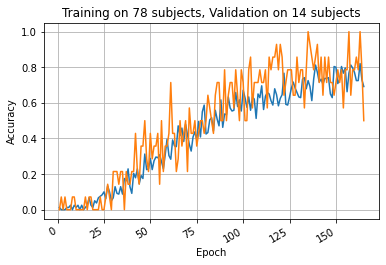

In [50]:
fig, ax = plt.subplots()
plot_accuracies(ax, train_losses, 'Training')
plot_accuracies(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
fig.autofmt_xdate()

## Dropout

In [53]:
exp_name = f'jiggsaw_puzzle_{n_permutations}_instance_norm_aug_dropout'

path_save = os.path.join(path_saved_models, f'{exp_name}.pth')

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

num_epochs = 500
dropout = 0.25
learning_rate = 1e-3
early_stop = 100

model = UnetEncoderSSL(normalization='instance', n_permutations=n_permutations, dropout=dropout)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = train(num_epochs, training_loader, validation_loader, 
                                 model, criterion, optimizer, path_save, early_stop)

Starting epoch 1


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.959	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.813	Accuracy: 0.00
Saving model at epoch: 1
Starting epoch 2


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.947	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.869	Accuracy: 0.07
Saving model at epoch: 2
Starting epoch 3


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.906	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.167	Accuracy: 0.00
Starting epoch 4


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.950	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.222	Accuracy: 0.00
Starting epoch 5


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.087	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.931	Accuracy: 0.07
Starting epoch 6


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.079	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.797	Accuracy: 0.00
Starting epoch 7


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.890	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.921	Accuracy: 0.00
Starting epoch 8


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.786	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.401	Accuracy: 0.00
Starting epoch 9


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.895	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.150	Accuracy: 0.00
Starting epoch 10


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.975	Accuracy: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.752	Accuracy: 0.00
Starting epoch 11


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.089	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.816	Accuracy: 0.14
Saving model at epoch: 11
Starting epoch 12


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.901	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.967	Accuracy: 0.00
Starting epoch 13


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.949	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.368	Accuracy: 0.00
Starting epoch 14


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.018	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.800	Accuracy: 0.00
Starting epoch 15


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.978	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.370	Accuracy: 0.14
Starting epoch 16


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.883	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.089	Accuracy: 0.00
Starting epoch 17


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.542	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.245	Accuracy: 0.07
Starting epoch 18


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.557	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.472	Accuracy: 0.07
Starting epoch 19


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.286	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.938	Accuracy: 0.07
Starting epoch 20


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.490	Accuracy: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.525	Accuracy: 0.07
Starting epoch 21


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.311	Accuracy: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.877	Accuracy: 0.00
Starting epoch 22


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.368	Accuracy: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.670	Accuracy: 0.07
Starting epoch 23


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.219	Accuracy: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.467	Accuracy: 0.00
Starting epoch 24


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.405	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.087	Accuracy: 0.14
Starting epoch 25


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.323	Accuracy: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.766	Accuracy: 0.07
Starting epoch 26


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.846	Accuracy: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.547	Accuracy: 0.00
Starting epoch 27


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.205	Accuracy: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.483	Accuracy: 0.14
Starting epoch 28


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.202	Accuracy: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.061	Accuracy: 0.07
Starting epoch 29


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.890	Accuracy: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.498	Accuracy: 0.21
Saving model at epoch: 29
Starting epoch 30


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.596	Accuracy: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.988	Accuracy: 0.36
Saving model at epoch: 30
Starting epoch 31


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.730	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.732	Accuracy: 0.00
Starting epoch 32


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.850	Accuracy: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.629	Accuracy: 0.14
Starting epoch 33


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.833	Accuracy: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.696	Accuracy: 0.29
Starting epoch 34


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.764	Accuracy: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.393	Accuracy: 0.07
Starting epoch 35


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.697	Accuracy: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.981	Accuracy: 0.00
Starting epoch 36


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.535	Accuracy: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.752	Accuracy: 0.07
Starting epoch 37


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.581	Accuracy: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.968	Accuracy: 0.00
Starting epoch 38


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.031	Accuracy: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.570	Accuracy: 0.21
Starting epoch 39


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.433	Accuracy: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.378	Accuracy: 0.14
Starting epoch 40


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.155	Accuracy: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.386	Accuracy: 0.07
Starting epoch 41


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.563	Accuracy: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.324	Accuracy: 0.14
Starting epoch 42


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.709	Accuracy: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.120	Accuracy: 0.21
Starting epoch 43


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.256	Accuracy: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.862	Accuracy: 0.21
Starting epoch 44


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.953	Accuracy: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.069	Accuracy: 0.21
Starting epoch 45


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.665	Accuracy: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.944	Accuracy: 0.07
Starting epoch 46


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.527	Accuracy: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.533	Accuracy: 0.14
Starting epoch 47


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.516	Accuracy: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.203	Accuracy: 0.29
Starting epoch 48


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.408	Accuracy: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.301	Accuracy: 0.29
Starting epoch 49


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.824	Accuracy: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.741	Accuracy: 0.14
Starting epoch 50


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.084	Accuracy: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.673	Accuracy: 0.29
Starting epoch 51


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.187	Accuracy: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.685	Accuracy: 0.21
Starting epoch 52


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.088	Accuracy: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.769	Accuracy: 0.36
Starting epoch 53


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.083	Accuracy: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.098	Accuracy: 0.07
Starting epoch 54


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.732	Accuracy: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.217	Accuracy: 0.43
Saving model at epoch: 54
Starting epoch 55


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.205	Accuracy: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.743	Accuracy: 0.21
Starting epoch 56


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.068	Accuracy: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.507	Accuracy: 0.36
Starting epoch 57


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.211	Accuracy: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.376	Accuracy: 0.43
Starting epoch 58


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.915	Accuracy: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.399	Accuracy: 0.50
Saving model at epoch: 58
Starting epoch 59


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.222	Accuracy: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.854	Accuracy: 0.50
Starting epoch 60


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.921	Accuracy: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.511	Accuracy: 0.36
Starting epoch 61


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.845	Accuracy: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.295	Accuracy: 0.43
Starting epoch 62


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.534	Accuracy: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.639	Accuracy: 0.36
Starting epoch 63


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.491	Accuracy: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.564	Accuracy: 0.43
Starting epoch 64


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.355	Accuracy: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.709	Accuracy: 0.14
Starting epoch 65


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.572	Accuracy: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.895	Accuracy: 0.36
Starting epoch 66


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.329	Accuracy: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.194	Accuracy: 0.50
Starting epoch 67


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.471	Accuracy: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.458	Accuracy: 0.14
Starting epoch 68


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.028	Accuracy: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.480	Accuracy: 0.50
Starting epoch 69


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.926	Accuracy: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.770	Accuracy: 0.43
Starting epoch 70


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.215	Accuracy: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.519	Accuracy: 0.57
Saving model at epoch: 70
Starting epoch 71


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.283	Accuracy: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.139	Accuracy: 0.57
Starting epoch 72


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.647	Accuracy: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.521	Accuracy: 0.50
Starting epoch 73


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.971	Accuracy: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.023	Accuracy: 0.50
Starting epoch 74


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.796	Accuracy: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.931	Accuracy: 0.64
Saving model at epoch: 74
Starting epoch 75


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.857	Accuracy: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.946	Accuracy: 0.50
Starting epoch 76


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.761	Accuracy: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.765	Accuracy: 0.29
Starting epoch 77


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.363	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.190	Accuracy: 0.36
Starting epoch 78


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.014	Accuracy: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.139	Accuracy: 0.50
Starting epoch 79


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.866	Accuracy: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.191	Accuracy: 0.57
Starting epoch 80


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.474	Accuracy: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.470	Accuracy: 0.21
Starting epoch 81


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.767	Accuracy: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.361	Accuracy: 0.29
Starting epoch 82


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.311	Accuracy: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.604	Accuracy: 0.79
Saving model at epoch: 82
Starting epoch 83


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.916	Accuracy: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.287	Accuracy: 0.29
Starting epoch 84


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.252	Accuracy: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.887	Accuracy: 0.71
Starting epoch 85


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.025	Accuracy: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.360	Accuracy: 0.43
Starting epoch 86


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.580	Accuracy: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.905	Accuracy: 0.57
Starting epoch 87


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.400	Accuracy: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.956	Accuracy: 0.57
Starting epoch 88


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.988	Accuracy: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.792	Accuracy: 0.71
Starting epoch 89


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.607	Accuracy: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.948	Accuracy: 0.43
Starting epoch 90


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.503	Accuracy: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.977	Accuracy: 0.64
Starting epoch 91


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.708	Accuracy: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.635	Accuracy: 0.50
Starting epoch 92


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.603	Accuracy: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.816	Accuracy: 0.64
Starting epoch 93


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.560	Accuracy: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.242	Accuracy: 0.36
Starting epoch 94


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.571	Accuracy: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.154	Accuracy: 0.64
Starting epoch 95


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.135	Accuracy: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.687	Accuracy: 0.64
Starting epoch 96


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.317	Accuracy: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.321	Accuracy: 0.64
Starting epoch 97


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.431	Accuracy: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.801	Accuracy: 0.64
Starting epoch 98


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.079	Accuracy: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.112	Accuracy: 0.64
Starting epoch 99


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.398	Accuracy: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.699	Accuracy: 0.86
Saving model at epoch: 99
Starting epoch 100


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.317	Accuracy: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.343	Accuracy: 0.57
Starting epoch 101


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.174	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.945	Accuracy: 0.64
Starting epoch 102


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.226	Accuracy: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.941	Accuracy: 0.86
Starting epoch 103


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.082	Accuracy: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.042	Accuracy: 0.50
Starting epoch 104


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.204	Accuracy: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.878	Accuracy: 0.79
Starting epoch 105


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.836	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.612	Accuracy: 0.50
Starting epoch 106


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.860	Accuracy: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.034	Accuracy: 0.71
Starting epoch 107


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.119	Accuracy: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.792	Accuracy: 0.57
Starting epoch 108


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.999	Accuracy: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.991	Accuracy: 0.29
Starting epoch 109


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.710	Accuracy: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.923	Accuracy: 0.79
Starting epoch 110


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.838	Accuracy: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.874	Accuracy: 0.57
Starting epoch 111


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.833	Accuracy: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.474	Accuracy: 0.71
Starting epoch 112


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.878	Accuracy: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.110	Accuracy: 0.79
Starting epoch 113


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.755	Accuracy: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.071	Accuracy: 0.57
Starting epoch 114


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.315	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.088	Accuracy: 0.71
Starting epoch 115


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.546	Accuracy: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.767	Accuracy: 0.79
Starting epoch 116


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.612	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.416	Accuracy: 0.64
Starting epoch 117


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.868	Accuracy: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.442	Accuracy: 0.64
Starting epoch 118


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.933	Accuracy: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.538	Accuracy: 0.50
Starting epoch 119


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.969	Accuracy: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.213	Accuracy: 0.79
Starting epoch 120


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.570	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.666	Accuracy: 0.86
Starting epoch 121


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.493	Accuracy: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.595	Accuracy: 0.86
Starting epoch 122


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.748	Accuracy: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.475	Accuracy: 0.86
Starting epoch 123


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.201	Accuracy: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.374	Accuracy: 0.93
Saving model at epoch: 123
Starting epoch 124


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.526	Accuracy: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.549	Accuracy: 0.57
Starting epoch 125


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.732	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.472	Accuracy: 0.57
Starting epoch 126


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.692	Accuracy: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.560	Accuracy: 0.64
Starting epoch 127


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.670	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.918	Accuracy: 0.79
Starting epoch 128


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.569	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.469	Accuracy: 0.64
Starting epoch 129


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.490	Accuracy: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.287	Accuracy: 0.71
Starting epoch 130


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.354	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.523	Accuracy: 0.71
Starting epoch 131


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.184	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.900	Accuracy: 0.79
Starting epoch 132


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.756	Accuracy: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.293	Accuracy: 0.71
Starting epoch 133


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.634	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.965	Accuracy: 0.50
Starting epoch 134


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.625	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.354	Accuracy: 0.86
Starting epoch 135


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.363	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.148	Accuracy: 0.71
Starting epoch 136


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.780	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.497	Accuracy: 0.86
Starting epoch 137


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.596	Accuracy: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.371	Accuracy: 0.79
Starting epoch 138


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.580	Accuracy: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.453	Accuracy: 0.86
Starting epoch 139


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.421	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.265	Accuracy: 0.71
Starting epoch 140


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.461	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.167	Accuracy: 0.93
Starting epoch 141


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.418	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.162	Accuracy: 0.64
Starting epoch 142


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.312	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.867	Accuracy: 0.64
Starting epoch 143


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.348	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.554	Accuracy: 0.86
Starting epoch 144


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.335	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.222	Accuracy: 0.71
Starting epoch 145


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.029	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.855	Accuracy: 0.64
Starting epoch 146


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.602	Accuracy: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.404	Accuracy: 0.64
Starting epoch 147


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.123	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.815	Accuracy: 0.64
Starting epoch 148


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.160	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.213	Accuracy: 0.64
Starting epoch 149


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.469	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.700	Accuracy: 0.86
Starting epoch 150


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.287	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.586	Accuracy: 0.79
Starting epoch 151


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.457	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.923	Accuracy: 0.71
Starting epoch 152


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.574	Accuracy: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.160	Accuracy: 0.79
Starting epoch 153


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.681	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.739	Accuracy: 0.86
Starting epoch 154


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.094	Accuracy: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.513	Accuracy: 0.86
Starting epoch 155


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.290	Accuracy: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.151	Accuracy: 0.71
Starting epoch 156


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.165	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.155	Accuracy: 1.00
Saving model at epoch: 156
Starting epoch 157


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.230	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.259	Accuracy: 0.93
Starting epoch 158


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.244	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.821	Accuracy: 0.71
Starting epoch 159


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.951	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.952	Accuracy: 0.64
Starting epoch 160


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.119	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.689	Accuracy: 0.71
Starting epoch 161


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.248	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.804	Accuracy: 0.86
Starting epoch 162


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.451	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.771	Accuracy: 0.79
Starting epoch 163


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.129	Accuracy: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.630	Accuracy: 0.79
Starting epoch 164


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.940	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.091	Accuracy: 0.71
Starting epoch 165


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.208	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.312	Accuracy: 0.71
Starting epoch 166


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.114	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.398	Accuracy: 0.64
Starting epoch 167


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.208	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.590	Accuracy: 0.86
Starting epoch 168


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.083	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.878	Accuracy: 0.64
Starting epoch 169


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.925	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.843	Accuracy: 0.71
Starting epoch 170


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.211	Accuracy: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.411	Accuracy: 0.93
Starting epoch 171


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.986	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.776	Accuracy: 0.64
Starting epoch 172


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.981	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.360	Accuracy: 0.86
Starting epoch 173


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.118	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.585	Accuracy: 0.86
Starting epoch 174


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.415	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.106	Accuracy: 0.79
Starting epoch 175


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.855	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.224	Accuracy: 0.57
Starting epoch 176


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.993	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.318	Accuracy: 0.86
Starting epoch 177


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.117	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.740	Accuracy: 0.79
Starting epoch 178


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.975	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.545	Accuracy: 0.79
Starting epoch 179


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.293	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.645	Accuracy: 0.79
Starting epoch 180


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.945	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.331	Accuracy: 0.93
Starting epoch 181


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.944	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.726	Accuracy: 0.79
Starting epoch 182


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.230	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.527	Accuracy: 0.86
Starting epoch 183


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.110	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.291	Accuracy: 0.86
Starting epoch 184


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.039	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.361	Accuracy: 0.93
Starting epoch 185


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.928	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.437	Accuracy: 0.71
Starting epoch 186


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.216	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.439	Accuracy: 0.86
Starting epoch 187


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.037	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.238	Accuracy: 0.64
Starting epoch 188


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.993	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.250	Accuracy: 0.93
Starting epoch 189


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.207	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.734	Accuracy: 0.86
Starting epoch 190


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.125	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.251	Accuracy: 1.00
Starting epoch 191


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.927	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.189	Accuracy: 0.93
Starting epoch 192


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.051	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.555	Accuracy: 0.79
Starting epoch 193


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.071	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.906	Accuracy: 0.93
Starting epoch 194


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.728	Accuracy: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.649	Accuracy: 0.86
Starting epoch 195


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.050	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.732	Accuracy: 0.79
Starting epoch 196


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.704	Accuracy: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.548	Accuracy: 0.86
Starting epoch 197


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.075	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.411	Accuracy: 0.86
Starting epoch 198


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.867	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.025	Accuracy: 0.71
Starting epoch 199


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.451	Accuracy: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.460	Accuracy: 0.86
Starting epoch 200


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.911	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.931	Accuracy: 0.64
Starting epoch 201


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.212	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.569	Accuracy: 0.93
Starting epoch 202


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.981	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.723	Accuracy: 0.86
Starting epoch 203


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.797	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.549	Accuracy: 0.79
Starting epoch 204


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.973	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.431	Accuracy: 0.86
Starting epoch 205


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.983	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.331	Accuracy: 0.86
Starting epoch 206


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.754	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.310	Accuracy: 0.71
Starting epoch 207


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.933	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.991	Accuracy: 0.86
Starting epoch 208


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.839	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.793	Accuracy: 0.79
Starting epoch 209


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.948	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.515	Accuracy: 0.86
Starting epoch 210


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.228	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.260	Accuracy: 0.93
Starting epoch 211


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.934	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.007	Accuracy: 0.64
Starting epoch 212


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.688	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.311	Accuracy: 0.93
Starting epoch 213


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.912	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.178	Accuracy: 1.00
Starting epoch 214


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.888	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.162	Accuracy: 0.71
Starting epoch 215


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.120	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.336	Accuracy: 0.86
Starting epoch 216


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.847	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.303	Accuracy: 0.86
Starting epoch 217


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.973	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.415	Accuracy: 0.93
Starting epoch 218


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.801	Accuracy: 0.87


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.876	Accuracy: 0.64
Starting epoch 219


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.733	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.363	Accuracy: 0.93
Starting epoch 220


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.839	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.773	Accuracy: 0.86
Starting epoch 221


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.757	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.509	Accuracy: 0.86
Starting epoch 222


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.634	Accuracy: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.318	Accuracy: 0.86
Starting epoch 223


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.803	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.069	Accuracy: 1.00
Starting epoch 224


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.821	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.177	Accuracy: 0.93
Starting epoch 225


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.140	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.360	Accuracy: 0.93
Starting epoch 226


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.949	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.372	Accuracy: 0.93
Starting epoch 227


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.669	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.682	Accuracy: 0.86
Starting epoch 228


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.740	Accuracy: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.940	Accuracy: 0.86
Starting epoch 229


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.784	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.730	Accuracy: 0.86
Starting epoch 230


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.670	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.187	Accuracy: 1.00
Starting epoch 231


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.870	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.328	Accuracy: 0.71
Starting epoch 232


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.739	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.454	Accuracy: 0.86
Starting epoch 233


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.841	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.616	Accuracy: 0.86
Starting epoch 234


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.906	Accuracy: 0.83


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.279	Accuracy: 0.93
Starting epoch 235


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.412	Accuracy: 0.88


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.475	Accuracy: 0.93
Starting epoch 236


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.701	Accuracy: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.410	Accuracy: 0.86
Starting epoch 237


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.888	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.162	Accuracy: 1.00
Starting epoch 238


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.534	Accuracy: 0.83


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.399	Accuracy: 0.71
Starting epoch 239


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.682	Accuracy: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.638	Accuracy: 0.86
Starting epoch 240


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.697	Accuracy: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.300	Accuracy: 0.93
Starting epoch 241


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.859	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.400	Accuracy: 0.93
Starting epoch 242


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.434	Accuracy: 0.88


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.314	Accuracy: 0.93
Starting epoch 243


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.678	Accuracy: 0.85


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.148	Accuracy: 0.93
Starting epoch 244


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.690	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.437	Accuracy: 0.93
Starting epoch 245


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.685	Accuracy: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.444	Accuracy: 0.86
Starting epoch 246


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.695	Accuracy: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.249	Accuracy: 0.86
Starting epoch 247


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.782	Accuracy: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.344	Accuracy: 0.79
Starting epoch 248


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.109	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.600	Accuracy: 0.86
Starting epoch 249


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.789	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.028	Accuracy: 0.79
Starting epoch 250


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.776	Accuracy: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.306	Accuracy: 0.93
Starting epoch 251


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.006	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Accuracy: 0.86
Starting epoch 252


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.755	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.862	Accuracy: 0.93
Starting epoch 253


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.629	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.330	Accuracy: 0.93
Starting epoch 254


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.878	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.418	Accuracy: 0.93
Starting epoch 255


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.000	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.808	Accuracy: 0.86
Starting epoch 256


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.767	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.767	Accuracy: 0.86
Stopping after 256 iterations...


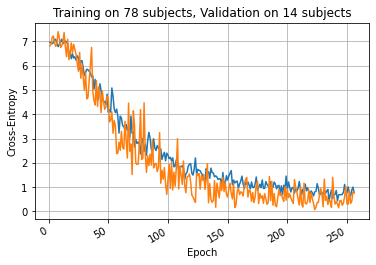

In [54]:
fig, ax = plt.subplots()
plot_epochs(ax, train_losses, 'Training')
plot_epochs(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-Entropy')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
fig.autofmt_xdate()

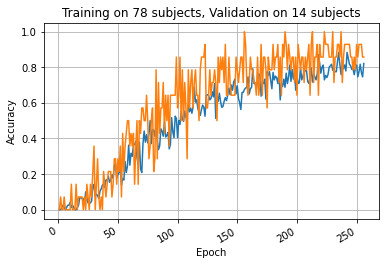

In [55]:
fig, ax = plt.subplots()
plot_accuracies(ax, train_losses, 'Training')
plot_accuracies(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
fig.autofmt_xdate()

In [58]:
exp_name = f'jiggsaw_puzzle_{n_permutations}_instance_norm_aug_dropout_higher'

path_save = os.path.join(path_saved_models, f'{exp_name}.pth')

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

num_epochs = 1000
dropout = 0.5
learning_rate = 1e-3
early_stop = 100

model = UnetEncoderSSL(normalization='instance', n_permutations=n_permutations, dropout=dropout)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = train(num_epochs, training_loader, validation_loader, 
                                 model, criterion, optimizer, path_save, early_stop)

Starting epoch 1


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.920	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.888	Accuracy: 0.00
Saving model at epoch: 1
Starting epoch 2


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.949	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.926	Accuracy: 0.00
Starting epoch 3


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.950	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.854	Accuracy: 0.00
Starting epoch 4


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.909	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.928	Accuracy: 0.07
Saving model at epoch: 4
Starting epoch 5


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.955	Accuracy: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.275	Accuracy: 0.00
Starting epoch 6


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.901	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.923	Accuracy: 0.00
Starting epoch 7


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.209	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.481	Accuracy: 0.00
Starting epoch 8


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.303	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.352	Accuracy: 0.00
Starting epoch 9


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.224	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.769	Accuracy: 0.07
Starting epoch 10


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.061	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.991	Accuracy: 0.07
Starting epoch 11


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.034	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.348	Accuracy: 0.00
Starting epoch 12


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.044	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.030	Accuracy: 0.07
Starting epoch 13


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.140	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.821	Accuracy: 0.07
Starting epoch 14


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.012	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.885	Accuracy: 0.00
Starting epoch 15


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.900	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.623	Accuracy: 0.14
Saving model at epoch: 15
Starting epoch 16


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 7.009	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.861	Accuracy: 0.07
Starting epoch 17


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.779	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.152	Accuracy: 0.00
Starting epoch 18


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.921	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.507	Accuracy: 0.00
Starting epoch 19


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.539	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.824	Accuracy: 0.00
Starting epoch 20


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.894	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.891	Accuracy: 0.00
Starting epoch 21


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.801	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.976	Accuracy: 0.00
Starting epoch 22


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.605	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.467	Accuracy: 0.00
Starting epoch 23


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.804	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.689	Accuracy: 0.00
Starting epoch 24


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.668	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.726	Accuracy: 0.07
Starting epoch 25


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.628	Accuracy: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.837	Accuracy: 0.07
Starting epoch 26


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.610	Accuracy: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.058	Accuracy: 0.00
Starting epoch 27


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.565	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 7.070	Accuracy: 0.00
Starting epoch 28


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.278	Accuracy: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.437	Accuracy: 0.00
Starting epoch 29


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.318	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.326	Accuracy: 0.00
Starting epoch 30


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.474	Accuracy: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.074	Accuracy: 0.21
Saving model at epoch: 30
Starting epoch 31


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.135	Accuracy: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.653	Accuracy: 0.00
Starting epoch 32


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.151	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.338	Accuracy: 0.07
Starting epoch 33


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.447	Accuracy: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.049	Accuracy: 0.07
Starting epoch 34


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.065	Accuracy: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.215	Accuracy: 0.21
Starting epoch 35


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.923	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.670	Accuracy: 0.21
Starting epoch 36


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.979	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 6.098	Accuracy: 0.07
Starting epoch 37


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.844	Accuracy: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.986	Accuracy: 0.07
Starting epoch 38


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 6.000	Accuracy: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.746	Accuracy: 0.07
Starting epoch 39


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.480	Accuracy: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.429	Accuracy: 0.21
Starting epoch 40


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.798	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.674	Accuracy: 0.07
Starting epoch 41


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.655	Accuracy: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.240	Accuracy: 0.29
Saving model at epoch: 41
Starting epoch 42


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.813	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.272	Accuracy: 0.29
Starting epoch 43


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.593	Accuracy: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.624	Accuracy: 0.07
Starting epoch 44


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.265	Accuracy: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.834	Accuracy: 0.14
Starting epoch 45


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.192	Accuracy: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.942	Accuracy: 0.21
Starting epoch 46


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.527	Accuracy: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.376	Accuracy: 0.14
Starting epoch 47


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.461	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.495	Accuracy: 0.14
Starting epoch 48


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.777	Accuracy: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 5.824	Accuracy: 0.07
Starting epoch 49


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.061	Accuracy: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.258	Accuracy: 0.07
Starting epoch 50


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.008	Accuracy: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.425	Accuracy: 0.29
Starting epoch 51


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.935	Accuracy: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.457	Accuracy: 0.36
Saving model at epoch: 51
Starting epoch 52


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.291	Accuracy: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.690	Accuracy: 0.36
Starting epoch 53


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.951	Accuracy: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.287	Accuracy: 0.64
Saving model at epoch: 53
Starting epoch 54


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.979	Accuracy: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.542	Accuracy: 0.14
Starting epoch 55


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.641	Accuracy: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.028	Accuracy: 0.07
Starting epoch 56


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.687	Accuracy: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.243	Accuracy: 0.21
Starting epoch 57


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.766	Accuracy: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.834	Accuracy: 0.21
Starting epoch 58


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 5.057	Accuracy: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.613	Accuracy: 0.21
Starting epoch 59


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.607	Accuracy: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.887	Accuracy: 0.14
Starting epoch 60


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.273	Accuracy: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.997	Accuracy: 0.14
Starting epoch 61


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.149	Accuracy: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.524	Accuracy: 0.29
Starting epoch 62


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.855	Accuracy: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.894	Accuracy: 0.36
Starting epoch 63


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.853	Accuracy: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.688	Accuracy: 0.21
Starting epoch 64


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.127	Accuracy: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.365	Accuracy: 0.21
Starting epoch 65


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.444	Accuracy: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.364	Accuracy: 0.50
Starting epoch 66


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.298	Accuracy: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.682	Accuracy: 0.29
Starting epoch 67


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.170	Accuracy: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.202	Accuracy: 0.14
Starting epoch 68


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.112	Accuracy: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.107	Accuracy: 0.29
Starting epoch 69


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.666	Accuracy: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.833	Accuracy: 0.29
Starting epoch 70


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 4.295	Accuracy: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.769	Accuracy: 0.57
Starting epoch 71


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.968	Accuracy: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.855	Accuracy: 0.29
Starting epoch 72


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.740	Accuracy: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.248	Accuracy: 0.29
Starting epoch 73


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.929	Accuracy: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 4.053	Accuracy: 0.21
Starting epoch 74


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.875	Accuracy: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.624	Accuracy: 0.57
Starting epoch 75


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.753	Accuracy: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.834	Accuracy: 0.36
Starting epoch 76


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.763	Accuracy: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.665	Accuracy: 0.29
Starting epoch 77


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.133	Accuracy: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.096	Accuracy: 0.36
Starting epoch 78


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.324	Accuracy: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.680	Accuracy: 0.29
Starting epoch 79


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.987	Accuracy: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.463	Accuracy: 0.29
Starting epoch 80


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.905	Accuracy: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.341	Accuracy: 0.36
Starting epoch 81


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.381	Accuracy: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.460	Accuracy: 0.43
Starting epoch 82


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.090	Accuracy: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.490	Accuracy: 0.21
Starting epoch 83


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.502	Accuracy: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.990	Accuracy: 0.57
Starting epoch 84


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.564	Accuracy: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.968	Accuracy: 0.50
Starting epoch 85


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.509	Accuracy: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.021	Accuracy: 0.50
Starting epoch 86


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.925	Accuracy: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.846	Accuracy: 0.64
Starting epoch 87


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.225	Accuracy: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.170	Accuracy: 0.36
Starting epoch 88


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.071	Accuracy: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.498	Accuracy: 0.43
Starting epoch 89


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.463	Accuracy: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.765	Accuracy: 0.79
Saving model at epoch: 89
Starting epoch 90


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.173	Accuracy: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.845	Accuracy: 0.21
Starting epoch 91


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.733	Accuracy: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.011	Accuracy: 0.50
Starting epoch 92


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.909	Accuracy: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.205	Accuracy: 0.57
Starting epoch 93


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.821	Accuracy: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.520	Accuracy: 0.64
Starting epoch 94


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.119	Accuracy: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.336	Accuracy: 0.57
Starting epoch 95


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.625	Accuracy: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.505	Accuracy: 0.50
Starting epoch 96


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.315	Accuracy: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.183	Accuracy: 0.21
Starting epoch 97


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.895	Accuracy: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.405	Accuracy: 0.71
Starting epoch 98


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.050	Accuracy: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.587	Accuracy: 0.64
Starting epoch 99


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.392	Accuracy: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.752	Accuracy: 0.21
Starting epoch 100


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.762	Accuracy: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.828	Accuracy: 0.57
Starting epoch 101


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.944	Accuracy: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.356	Accuracy: 0.43
Starting epoch 102


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.915	Accuracy: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.517	Accuracy: 0.71
Starting epoch 103


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.632	Accuracy: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.784	Accuracy: 0.57
Starting epoch 104


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.674	Accuracy: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.555	Accuracy: 0.43
Starting epoch 105


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 3.088	Accuracy: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.891	Accuracy: 0.79
Starting epoch 106


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.383	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.004	Accuracy: 0.50
Starting epoch 107


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.497	Accuracy: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.353	Accuracy: 0.79
Starting epoch 108


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.596	Accuracy: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.945	Accuracy: 0.29
Starting epoch 109


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.425	Accuracy: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.145	Accuracy: 0.36
Starting epoch 110


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.950	Accuracy: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.469	Accuracy: 0.57
Starting epoch 111


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.757	Accuracy: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.996	Accuracy: 0.71
Starting epoch 112


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.460	Accuracy: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.305	Accuracy: 0.57
Starting epoch 113


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.504	Accuracy: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.415	Accuracy: 0.50
Starting epoch 114


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.583	Accuracy: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.315	Accuracy: 0.64
Starting epoch 115


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.982	Accuracy: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 3.056	Accuracy: 0.36
Starting epoch 116


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.375	Accuracy: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.402	Accuracy: 0.71
Starting epoch 117


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.318	Accuracy: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.075	Accuracy: 0.50
Starting epoch 118


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.155	Accuracy: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.582	Accuracy: 0.57
Starting epoch 119


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.582	Accuracy: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.794	Accuracy: 0.64
Starting epoch 120


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.969	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.160	Accuracy: 0.57
Starting epoch 121


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.208	Accuracy: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.263	Accuracy: 0.50
Starting epoch 122


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.944	Accuracy: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.739	Accuracy: 0.57
Starting epoch 123


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.191	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.650	Accuracy: 0.64
Starting epoch 124


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.492	Accuracy: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.079	Accuracy: 0.50
Starting epoch 125


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.267	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.133	Accuracy: 0.79
Starting epoch 126


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.368	Accuracy: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.274	Accuracy: 0.64
Starting epoch 127


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.342	Accuracy: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.585	Accuracy: 0.86
Saving model at epoch: 127
Starting epoch 128


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.155	Accuracy: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.383	Accuracy: 0.79
Starting epoch 129


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.938	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.368	Accuracy: 0.64
Starting epoch 130


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.169	Accuracy: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.664	Accuracy: 0.50
Starting epoch 131


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.731	Accuracy: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.108	Accuracy: 0.71
Starting epoch 132


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.946	Accuracy: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.038	Accuracy: 0.71
Starting epoch 133


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.131	Accuracy: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.762	Accuracy: 0.86
Starting epoch 134


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.772	Accuracy: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.779	Accuracy: 0.71
Starting epoch 135


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.983	Accuracy: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.137	Accuracy: 0.79
Starting epoch 136


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.805	Accuracy: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.561	Accuracy: 0.50
Starting epoch 137


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.692	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.781	Accuracy: 0.79
Starting epoch 138


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.501	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.412	Accuracy: 0.86
Starting epoch 139


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.997	Accuracy: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.745	Accuracy: 0.79
Starting epoch 140


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.247	Accuracy: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.957	Accuracy: 0.43
Starting epoch 141


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.848	Accuracy: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.473	Accuracy: 0.86
Starting epoch 142


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.901	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.991	Accuracy: 0.79
Starting epoch 143


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.652	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 2.204	Accuracy: 0.64
Starting epoch 144


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.939	Accuracy: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.951	Accuracy: 0.64
Starting epoch 145


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.837	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.785	Accuracy: 0.43
Starting epoch 146


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.395	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.510	Accuracy: 0.57
Starting epoch 147


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.775	Accuracy: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.403	Accuracy: 0.64
Starting epoch 148


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.388	Accuracy: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.409	Accuracy: 0.86
Starting epoch 149


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.958	Accuracy: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.564	Accuracy: 0.57
Starting epoch 150


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 2.002	Accuracy: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.102	Accuracy: 0.71
Starting epoch 151


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.852	Accuracy: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.616	Accuracy: 0.86
Starting epoch 152


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.585	Accuracy: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.809	Accuracy: 0.71
Starting epoch 153


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.435	Accuracy: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.364	Accuracy: 0.57
Starting epoch 154


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.739	Accuracy: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.198	Accuracy: 0.79
Starting epoch 155


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.205	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.767	Accuracy: 0.79
Starting epoch 156


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.585	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.151	Accuracy: 0.71
Starting epoch 157


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.723	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.536	Accuracy: 0.86
Starting epoch 158


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.544	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.864	Accuracy: 0.79
Starting epoch 159


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.777	Accuracy: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.866	Accuracy: 0.64
Starting epoch 160


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.347	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.066	Accuracy: 0.64
Starting epoch 161


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.720	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.215	Accuracy: 0.64
Starting epoch 162


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.700	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.889	Accuracy: 0.86
Starting epoch 163


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.848	Accuracy: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.541	Accuracy: 0.57
Starting epoch 164


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.262	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.135	Accuracy: 0.79
Starting epoch 165


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.278	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.901	Accuracy: 0.71
Starting epoch 166


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.806	Accuracy: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.233	Accuracy: 0.93
Saving model at epoch: 166
Starting epoch 167


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.415	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.386	Accuracy: 0.93
Starting epoch 168


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.561	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.823	Accuracy: 0.79
Starting epoch 169


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.587	Accuracy: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.292	Accuracy: 0.64
Starting epoch 170


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.182	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.650	Accuracy: 0.86
Starting epoch 171


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.730	Accuracy: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.448	Accuracy: 0.50
Starting epoch 172


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.531	Accuracy: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.796	Accuracy: 0.79
Starting epoch 173


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.744	Accuracy: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.880	Accuracy: 0.79
Starting epoch 174


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.581	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.616	Accuracy: 0.86
Starting epoch 175


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.484	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.685	Accuracy: 0.79
Starting epoch 176


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.246	Accuracy: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.791	Accuracy: 0.71
Starting epoch 177


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.161	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.336	Accuracy: 0.57
Starting epoch 178


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.544	Accuracy: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.104	Accuracy: 0.57
Starting epoch 179


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.214	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.482	Accuracy: 0.86
Starting epoch 180


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.114	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.212	Accuracy: 0.93
Starting epoch 181


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.467	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.505	Accuracy: 0.64
Starting epoch 182


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.353	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.843	Accuracy: 0.71
Starting epoch 183


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.384	Accuracy: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.042	Accuracy: 0.79
Starting epoch 184


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.168	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.957	Accuracy: 0.86
Starting epoch 185


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.399	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.666	Accuracy: 0.79
Starting epoch 186


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.412	Accuracy: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.911	Accuracy: 0.79
Starting epoch 187


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.178	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.533	Accuracy: 0.79
Starting epoch 188


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.384	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.935	Accuracy: 0.79
Starting epoch 189


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.364	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.505	Accuracy: 0.79
Starting epoch 190


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.615	Accuracy: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.918	Accuracy: 0.86
Starting epoch 191


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.068	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.837	Accuracy: 0.71
Starting epoch 192


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.485	Accuracy: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.138	Accuracy: 0.71
Starting epoch 193


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.865	Accuracy: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.682	Accuracy: 0.71
Starting epoch 194


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.279	Accuracy: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.503	Accuracy: 0.93
Starting epoch 195


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.302	Accuracy: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.353	Accuracy: 0.93
Starting epoch 196


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.441	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.424	Accuracy: 0.86
Starting epoch 197


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.310	Accuracy: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.217	Accuracy: 0.93
Starting epoch 198


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.136	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.032	Accuracy: 0.71
Starting epoch 199


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.577	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.588	Accuracy: 0.86
Starting epoch 200


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.406	Accuracy: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.996	Accuracy: 0.64
Starting epoch 201


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.995	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.695	Accuracy: 0.86
Starting epoch 202


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.137	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.830	Accuracy: 0.64
Starting epoch 203


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.357	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.677	Accuracy: 0.71
Starting epoch 204


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.113	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.481	Accuracy: 0.86
Starting epoch 205


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.156	Accuracy: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.668	Accuracy: 0.71
Starting epoch 206


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.894	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.555	Accuracy: 0.79
Starting epoch 207


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.022	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.531	Accuracy: 0.79
Starting epoch 208


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.265	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.867	Accuracy: 0.79
Starting epoch 209


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.059	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.717	Accuracy: 0.86
Starting epoch 210


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.959	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.897	Accuracy: 0.57
Starting epoch 211


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.065	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.805	Accuracy: 0.64
Starting epoch 212


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.213	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.450	Accuracy: 0.79
Starting epoch 213


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.210	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.999	Accuracy: 0.64
Starting epoch 214


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.221	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Accuracy: 0.93
Starting epoch 215


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.151	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.134	Accuracy: 0.64
Starting epoch 216


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.887	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.551	Accuracy: 0.86
Starting epoch 217


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.166	Accuracy: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.560	Accuracy: 0.86
Starting epoch 218


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.020	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.956	Accuracy: 0.71
Starting epoch 219


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.582	Accuracy: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.053	Accuracy: 0.79
Starting epoch 220


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.370	Accuracy: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.740	Accuracy: 0.79
Starting epoch 221


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.703	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.504	Accuracy: 0.86
Starting epoch 222


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.104	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.445	Accuracy: 0.71
Starting epoch 223


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.131	Accuracy: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.662	Accuracy: 0.86
Starting epoch 224


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.144	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.128	Accuracy: 1.00
Saving model at epoch: 224
Starting epoch 225


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.272	Accuracy: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.018	Accuracy: 0.79
Starting epoch 226


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.992	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.636	Accuracy: 0.71
Starting epoch 227


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.956	Accuracy: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.474	Accuracy: 0.86
Starting epoch 228


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.050	Accuracy: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.677	Accuracy: 0.86
Starting epoch 229


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.947	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.359	Accuracy: 0.93
Starting epoch 230


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.145	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.313	Accuracy: 0.64
Starting epoch 231


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.937	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.518	Accuracy: 0.79
Starting epoch 232


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.057	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.715	Accuracy: 0.86
Starting epoch 233


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.058	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.124	Accuracy: 1.00
Starting epoch 234


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.041	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.331	Accuracy: 0.71
Starting epoch 235


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.966	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.007	Accuracy: 0.71
Starting epoch 236


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.680	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.310	Accuracy: 0.86
Starting epoch 237


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.936	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.290	Accuracy: 0.93
Starting epoch 238


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.824	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.584	Accuracy: 0.79
Starting epoch 239


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.107	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.516	Accuracy: 0.93
Starting epoch 240


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.298	Accuracy: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.238	Accuracy: 0.93
Starting epoch 241


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.020	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.451	Accuracy: 0.79
Starting epoch 242


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.719	Accuracy: 0.84


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.730	Accuracy: 0.79
Starting epoch 243


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.048	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.567	Accuracy: 0.79
Starting epoch 244


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.853	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.735	Accuracy: 0.86
Starting epoch 245


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.950	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.235	Accuracy: 1.00
Starting epoch 246


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.959	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.376	Accuracy: 0.93
Starting epoch 247


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.151	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.917	Accuracy: 0.79
Starting epoch 248


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.645	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.049	Accuracy: 0.71
Starting epoch 249


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.935	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.552	Accuracy: 0.93
Starting epoch 250


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.925	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.364	Accuracy: 0.71
Starting epoch 251


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.607	Accuracy: 0.84


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.802	Accuracy: 0.79
Starting epoch 252


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.637	Accuracy: 0.86


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.807	Accuracy: 0.79
Starting epoch 253


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.863	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.371	Accuracy: 0.86
Starting epoch 254


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.883	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.626	Accuracy: 0.86
Starting epoch 255


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.679	Accuracy: 0.85


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.148	Accuracy: 0.93
Starting epoch 256


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.147	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.692	Accuracy: 0.71
Starting epoch 257


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.721	Accuracy: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.188	Accuracy: 0.93
Starting epoch 258


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.835	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.494	Accuracy: 0.93
Starting epoch 259


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.883	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.852	Accuracy: 0.71
Starting epoch 260


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.647	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.393	Accuracy: 0.86
Starting epoch 261


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.147	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.019	Accuracy: 1.00
Starting epoch 262


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.273	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.279	Accuracy: 0.86
Starting epoch 263


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.863	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.506	Accuracy: 0.86
Starting epoch 264


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.994	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Accuracy: 0.93
Starting epoch 265


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.949	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.544	Accuracy: 0.79
Starting epoch 266


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.784	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.188	Accuracy: 0.93
Starting epoch 267


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.968	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.687	Accuracy: 0.79
Starting epoch 268


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.017	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.821	Accuracy: 0.71
Starting epoch 269


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.868	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.219	Accuracy: 1.00
Starting epoch 270


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.230	Accuracy: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.266	Accuracy: 0.93
Starting epoch 271


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.039	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.423	Accuracy: 0.86
Starting epoch 272


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.835	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.716	Accuracy: 0.71
Starting epoch 273


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.123	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.628	Accuracy: 0.64
Starting epoch 274


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.734	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.359	Accuracy: 0.79
Starting epoch 275


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.928	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.456	Accuracy: 0.79
Starting epoch 276


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.878	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.271	Accuracy: 0.93
Starting epoch 277


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.012	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.204	Accuracy: 0.93
Starting epoch 278


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.319	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.251	Accuracy: 0.71
Starting epoch 279


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.791	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.735	Accuracy: 0.86
Starting epoch 280


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.974	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.962	Accuracy: 0.79
Starting epoch 281


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.097	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.351	Accuracy: 0.86
Starting epoch 282


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.833	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.842	Accuracy: 0.79
Starting epoch 283


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.984	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.304	Accuracy: 0.93
Starting epoch 284


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.962	Accuracy: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.617	Accuracy: 0.79
Starting epoch 285


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.049	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.896	Accuracy: 0.79
Starting epoch 286


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.743	Accuracy: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.567	Accuracy: 0.93
Starting epoch 287


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.993	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.579	Accuracy: 0.93
Starting epoch 288


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.667	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.046	Accuracy: 0.71
Starting epoch 289


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.941	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.325	Accuracy: 0.93
Starting epoch 290


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.071	Accuracy: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.177	Accuracy: 0.71
Starting epoch 291


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.722	Accuracy: 0.83


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.555	Accuracy: 0.79
Starting epoch 292


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.769	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.283	Accuracy: 0.93
Starting epoch 293


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.105	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.153	Accuracy: 0.93
Starting epoch 294


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.867	Accuracy: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.261	Accuracy: 0.93
Starting epoch 295


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.814	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.329	Accuracy: 0.86
Starting epoch 296


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.835	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.833	Accuracy: 0.71
Starting epoch 297


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.991	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.538	Accuracy: 0.86
Starting epoch 298


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.884	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.390	Accuracy: 0.86
Starting epoch 299


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.010	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.017	Accuracy: 1.00
Starting epoch 300


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.017	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.199	Accuracy: 0.93
Starting epoch 301


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.817	Accuracy: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.937	Accuracy: 0.71
Starting epoch 302


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.730	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.329	Accuracy: 0.86
Starting epoch 303


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.159	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.585	Accuracy: 0.79
Starting epoch 304


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.830	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.091	Accuracy: 0.93
Starting epoch 305


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.857	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.342	Accuracy: 0.93
Starting epoch 306


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.073	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.252	Accuracy: 0.86
Starting epoch 307


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.119	Accuracy: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 1.394	Accuracy: 0.64
Starting epoch 308


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.951	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.079	Accuracy: 1.00
Starting epoch 309


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.000	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.257	Accuracy: 0.93
Starting epoch 310


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.758	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.975	Accuracy: 0.79
Starting epoch 311


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.826	Accuracy: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.896	Accuracy: 0.86
Starting epoch 312


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.779	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.619	Accuracy: 0.79
Starting epoch 313


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.646	Accuracy: 0.82


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.810	Accuracy: 0.79
Starting epoch 314


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.700	Accuracy: 0.80


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.225	Accuracy: 0.93
Starting epoch 315


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.538	Accuracy: 0.86


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.216	Accuracy: 0.93
Starting epoch 316


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.060	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.331	Accuracy: 0.93
Starting epoch 317


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.044	Accuracy: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.570	Accuracy: 0.79
Starting epoch 318


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.738	Accuracy: 0.84


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.950	Accuracy: 0.79
Starting epoch 319


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.503	Accuracy: 0.86


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.513	Accuracy: 0.86
Starting epoch 320


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 1.180	Accuracy: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.487	Accuracy: 0.93
Starting epoch 321


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.895	Accuracy: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.524	Accuracy: 0.93
Starting epoch 322


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.830	Accuracy: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.224	Accuracy: 0.93
Starting epoch 323


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.834	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.792	Accuracy: 0.86
Starting epoch 324


  0%|          | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.827	Accuracy: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.508	Accuracy: 0.79
Stopping after 324 iterations...


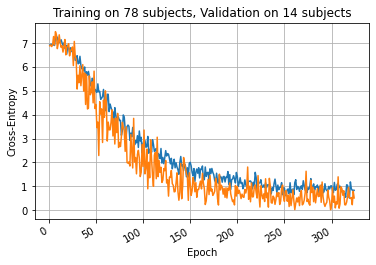

In [59]:
fig, ax = plt.subplots()
plot_epochs(ax, train_losses, 'Training')
plot_epochs(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-Entropy')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
fig.autofmt_xdate()

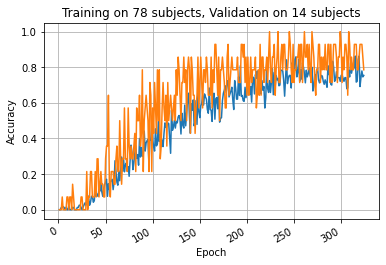

In [60]:
fig, ax = plt.subplots()
plot_accuracies(ax, train_losses, 'Training')
plot_accuracies(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
fig.autofmt_xdate()